# AIPI 590 - XAI | Assignment #02
### Interpreatble ML
### Rebecca Du (rrd17)



[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rrdu/AIPI-590/blob/main/HW2/AIPI590_InterpretableML.ipynb)


In [1]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "AIPI-590" # Change to your repo name
git_path ='https://github.com/rrdu/AIPI-590.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'HW2'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

rm: cannot remove './sample_data': No such file or directory
fatal: destination path 'AIPI-590' already exists and is not an empty directory.
/content/AIPI-590/HW2
AIPI-590/  AIPI590_InterpretableML.ipynb


## Overview

I was tasked with recommending interpretable ML models for a telecommunications company dealing with customer churn.

The dataset for this problem comes from [Kaggle](https://www.kaggle.com/datasets/blastchar/telco-customer-churn/code).

The notebook is structured as follows:

1) **Exploratory Data Analysis and Check Assumptions**
    - 1.1) Exploratory Data Analysis
      - 1.1a) Loading Data
      - 1.1b) Check for missing values, data types
      - 1.1c) Analyze how features relate to churn
    - 1.2) Assumptions Overview
2) **Linear Regression**
    - 2.1) Make Linear Regression Model
    - 2.2) Interpret Coefficients
    - 2.3) Check for Assumptions
    - 2.4) Evaluate Performance
3) **Logistic Regression**
    - 3.1) Make Logistic Regression Model
    - 3.2) Interpret Coefficients
    - 3.3) Check for Assumptions
    - 3.4) Evaluate Performance
4) **Generalized Additive Models (GAM)**
    - 4.1) Make GAM Model
    - 4.2) Interpret Coefficients
    - 4.3) Check for Assumptions
    - 4.4) Evaluate Performance
5) **Model Comparison**
6) **Model Recommendation**



## 1) Exploratory Data Analysis and Check Assumptions

### 1.1) Exploratory Data Analysis

First, we conduct the following basic exploratory data analysis steps:

a. Load the data

b. Check for missing values, data types

c. Analyze how features related to target variable (churn)

In [2]:
!pip install pygam --quiet

In [33]:
#Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.sparse as sps
import math

from google.colab import drive

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer

from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.genmod.families import Gamma
from statsmodels.genmod.families.links import Log
from statsmodels.tools import add_constant
from pygam import LinearGAM, LogisticGAM, GammaGAM, s, f
from numpy.linalg import inv


#### 1.1a) Load Data

In [4]:
#Mount Google Drive to access data
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/Colab Notebooks/AIPI590/HW2/Telco-Customer-Churn.csv"
df = pd.read_csv(file_path)

#Check data
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### 1.1b) Check for Missing Values, Data Types

In [5]:
#Check if there are missing values
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [6]:
#Drop customerID because it is arbitrary and unrelated to Churn
df = df.drop(columns=['customerID'])

#Check data type of remaining features
df.dtypes

,0
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object
OnlineBackup,object


We see that many of the features are of the object (string) data type, so we convert them to the category datatype to make visualization easier.

In [7]:
#Convert object datatypes to category
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category')

df.dtypes

,0
gender,category
SeniorCitizen,int64
Partner,category
Dependents,category
tenure,int64
PhoneService,category
MultipleLines,category
InternetService,category
OnlineSecurity,category
OnlineBackup,category


#### 1.1c) Analyze How Features Relate to Target Variable (Churn)

The following steps will be taken:
- Overview of churn distribution
- Categorical features vs. churn
- Numerical features vs. churn
- Brief summary of findings

First, we examine the overview of the churn distribution using a simple bar plot.

<Axes: xlabel='Churn', ylabel='count'>

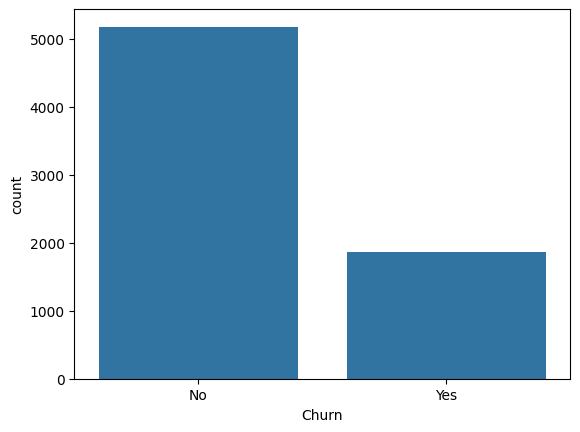

In [8]:
#First, see general distribution of churn
sns.countplot(x='Churn', data=df)

Next, we look at how categorical features relate to churn.

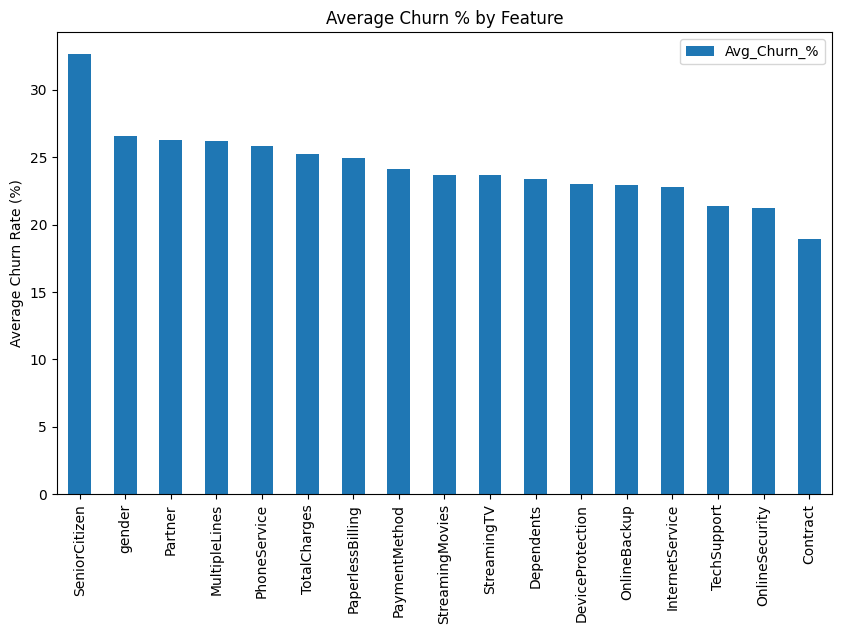

In [9]:
#Convert Senior Citizen to Category
df['SeniorCitizen'] = (
    df['SeniorCitizen']
      .map({0: 'No', 1: 'Yes'})
      .astype('category')
)

#Categorical features vs. churn
categorical_features = df.select_dtypes(include='category').columns.tolist()
categorical_features.remove('Churn')

churn_rates = {}

for col in categorical_features:
    churn_rate = pd.crosstab(df[col], df['Churn'], normalize='index')['Yes'] * 100
    #Calculate average churn rate across feature
    churn_rates[col] = churn_rate.mean()

summary_df = pd.DataFrame.from_dict(churn_rates, orient='index', columns=['Avg_Churn_%'])
summary_df.sort_values('Avg_Churn_%', ascending=False).plot(kind='bar', figsize=(10,6))
plt.title("Average Churn % by Feature")
plt.ylabel("Average Churn Rate (%)")
plt.show()



Now we look at how the numerical features relate to churn.

/tmp/ipython-input-2559679780.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby('Churn')[numerical_features].mean().T


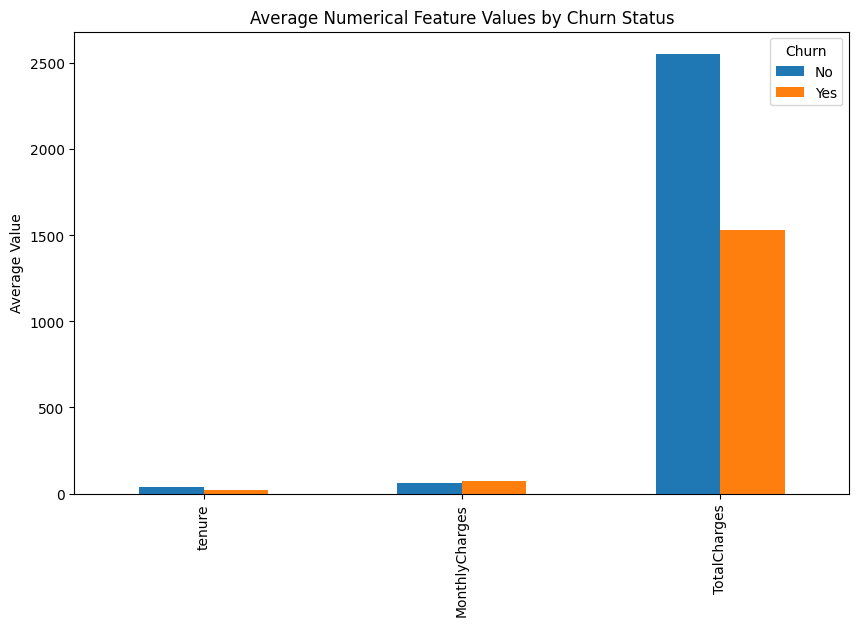

In [10]:
#Convert TotalCharges to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

#Numerical features vs. churn
numerical_features = ['tenure','MonthlyCharges', 'TotalCharges']
means = df.groupby('Churn')[numerical_features].mean().T

means.plot(kind='bar', figsize=(10,6))
plt.title("Average Numerical Feature Values by Churn Status")
plt.ylabel("Average Value")
plt.show()

From the exploratory data analysis, we can make the following observations:

- For the churn variable overall, there seems to be more people who do NOT churn (i.e. they stay with the company) compared to those who DO churn.
- For **categorical features**, most of them have churn rates around 25%.
  - In particular, contract length and service-related features (TechSupport, OnlineSecurity) have lower churn rates, potentially making them good indicators of churn likelihood.
- For **numerical features**, we see that the bar for TotalCharges is notably higher than the other features.
  - This may be because TotalCharges is calculated as tenure x MonthlyCharges.



### 1.2) Checking Assumptions

The models we will be testing are:
- Linear regression
- Logistic regression
- Generalized additive model (GAM)

The following table summarizes the assumptions for each model. The listed tests for assumption will be performed after the models are created since many need residuals.

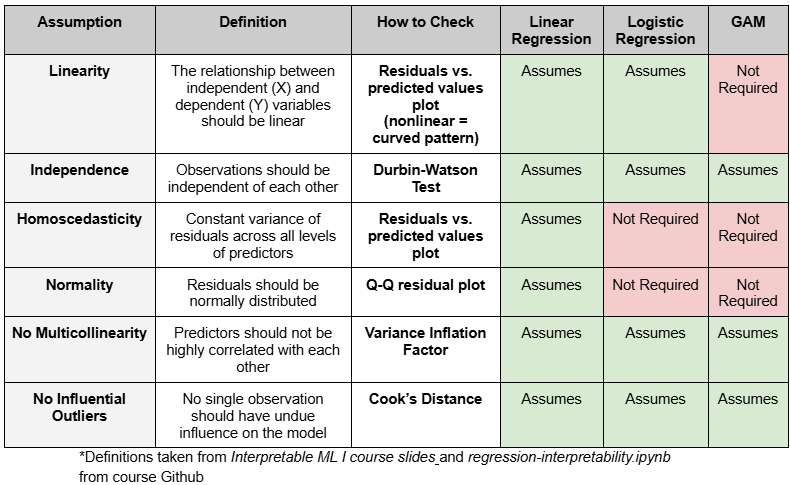

## 2) Linear Regression

In **linear regression**, the coefficients directly show the impact of each feature on the target variable.*


*Taken from regression-interpretability.ipynb from course Github



### 2.1) Make Linear Regression Model

In [11]:
#Convert TotalCharges to numeric
if "TotalCharges" in df.columns:
    df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

#Treat churn as continuous variable
df['Churn_num'] = df['Churn'].map({'Yes': 1, 'No': 0}).astype(int)
y = df['Churn_num']
X = df.drop(columns=['Churn_num', 'Churn'])

numerical_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

#One-hot encode categorical data, scale numerical data
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_final = preprocess.fit_transform(X_train)
X_test_final  = preprocess.transform(X_test)
feature_names = preprocess.get_feature_names_out()

In [12]:
#Evaluate model
def evaluate_linear_model(model, X_train, X_test, y_train, y_test, model_name, feat_names):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{model_name}:")
    print(f"MSE: {mse:.2f}")
    print(f"R2 Score: {r2:.2f}")

    coefs = np.ravel(model.coef_)
    for f, c in sorted(zip(feat_names, coefs), key=lambda x: abs(x[1]), reverse=True)[:20]:
      print(f"{f}: {c:.4f}")

    return model, y_pred

In [13]:
#Fit and evaluate model
linear_model, linear_pred = evaluate_linear_model(LinearRegression(), X_train_final, X_test_final,
                                   y_train, y_test, "Linear Regression", feature_names)


Linear Regression:
MSE: 0.13
R2 Score: 0.31
InternetService_Fiber optic: 0.2812
MonthlyCharges: -0.1336
Contract_One year: -0.1073
StreamingMovies_Yes: 0.1070
TotalCharges: -0.0952
StreamingTV_Yes: 0.0882
Contract_Two year: -0.0808
MultipleLines_Yes: 0.0714
PaymentMethod_Electronic check: 0.0706
tenure: -0.0470
PaperlessBilling_Yes: 0.0454
SeniorCitizen_Yes: 0.0378
InternetService_No: -0.0364
OnlineBackup_No internet service: -0.0364
DeviceProtection_No internet service: -0.0364
TechSupport_No internet service: -0.0364
StreamingTV_No internet service: -0.0364
StreamingMovies_No internet service: -0.0364
OnlineSecurity_No internet service: -0.0364
OnlineSecurity_Yes: -0.0350


### 2.2) Interpret Coefficients

The coefficients determine the relative impact of each feature on churn probability. The closer the value is to either 1 or -1 indicates the strength of the impact.
- **Positive coefficients** mean the feature is associated with a high probability of churn
  - I.e. customer with this feature is likely to churn
- **Negative coefficients** mean the feature is associated with a low probability of churn
  - I.e. customer with this feature is unlikely to churn

The following features had notable coefficients:
- **InternetService_Fiber optic = 0.2812**: this shows that customers who have fiber optic are likely to churn.
- **MonthlyCharges = -0.13**: interestingly, customers with higher monthly charges are less likely to churn. This could be explained by the customers being loyal to the company.
- **Contract_One year = -0.1073, Contract_Two year = -0.0808**: customers with longer contracts are slightly less likely to churn.
- **StreamingMovies_Yes = 0.1070, StreamingTV_Yes = 0.0882**: customers that stream movies and TV are slightly likely to churn, perhaps due to the compounded cost of additional features.
- **PaymentMethod_Electronic check = 0.0706**: customers paying by electronic check are more likely to churn.
- **Tenure = -0.0470**: intuitively, having a longer tenure with the company means the customer is less likely to churn because they are loyal.
- **OnlineSecurity_Yes = -0.0350, TechSupport_Yes = -0.0270**: the presence of security and techn support lowers churn likelihood.


### 2.3) Check for Assumptions

For linear regression, we must check:

a) **Linearity and Homoscedasticity**: resdiuals vs. predicted values plot

b) **Independence**: Durbin-Watson test

c) **Normality**: Q-Q residual plot

d) **No Multicollinearity**: VIF test

e) **No Influential Outliers**: Cook's Distance

#### 2.3a) Linearity and Homoscedasticity

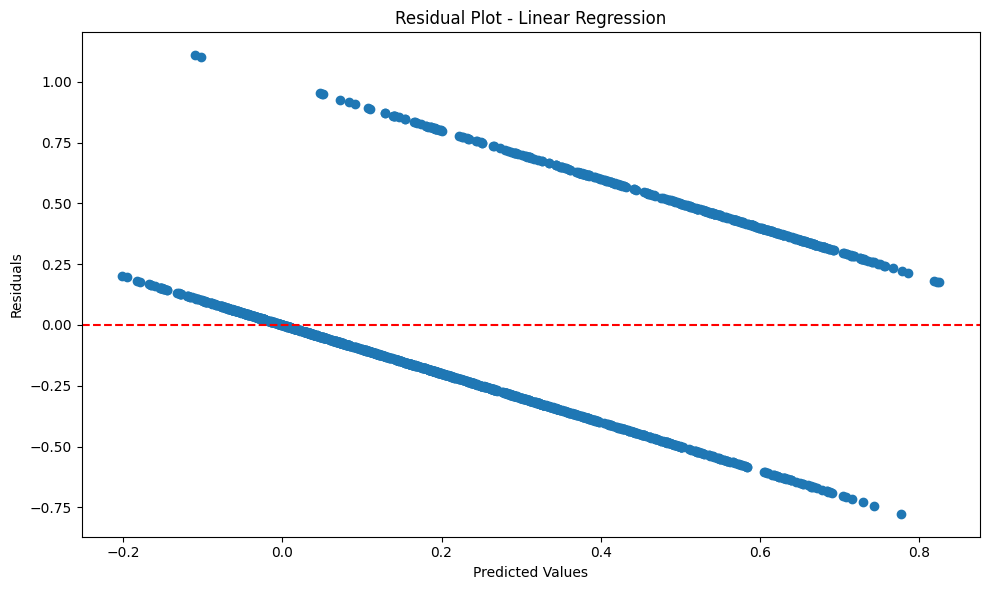

In [14]:
# Residual Plot
def plot_residuals(y_test, y_pred, model_name):
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot - {model_name}')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.tight_layout()
    plt.show()

plot_residuals(y_test, linear_pred, 'Linear Regression')

The plot shows that the points are not randomly scattered, indicating that the assumptions regarding **Linearity and Homoscedasticity are both violated.**

This can be explained by the fact that churn is a binary outcome, which linear regression is not suited to capturing (it works better for continuous data).

#### 2.3b) Independence

In [15]:
#Perform Durbin-Watson test
residuals = y_test - linear_pred
dw = durbin_watson(residuals)
print("Durbin-Watson statistic:", dw)

Durbin-Watson statistic: 1.8882377387325229


For the Durbin-Watson test for independence, values around 2 indicate no autocorrelation.

Thus, the **independence assumption is satisifed.**

#### 2.3c) Normality

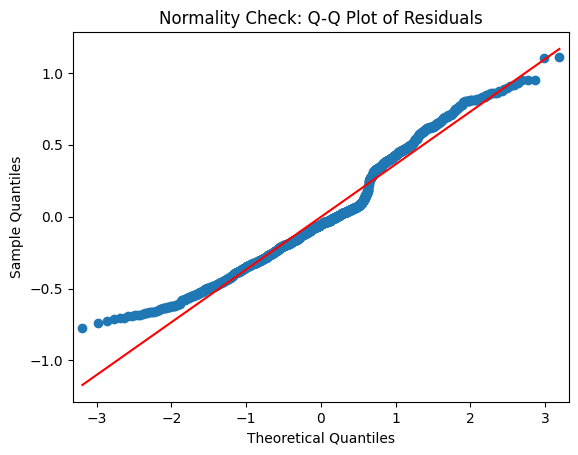

In [16]:
#Create Q-Q plot
sm.qqplot(residuals, line='s')
plt.title('Normality Check: Q-Q Plot of Residuals')
plt.show()

The red line in the Q-Q plot represents the line of perfect normality whereas the blue dots are the actual residuals.

From this, we can see that the **residuals are roughly normally distributed**.

#### 2.3d) No Multicollinearity

In [17]:
#Perform VIF (generated using GPT-5 on 9/11/25 at 5:41 PM)
X_vif = sm.add_constant(df[numerical_features])
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                   for i in range(X_vif.shape[1])]

print(vif_data)

          Feature        VIF
0           const  14.743556
1          tenure   5.769167
2  MonthlyCharges   3.189082
3    TotalCharges   9.394268


Values around 1 demonstrate no collinearity.

However, for many of the features the VIF is above 1, demonstrating that the **no multicollinearity assumption is violated**.

#### 2.3e) No Influential Outliers

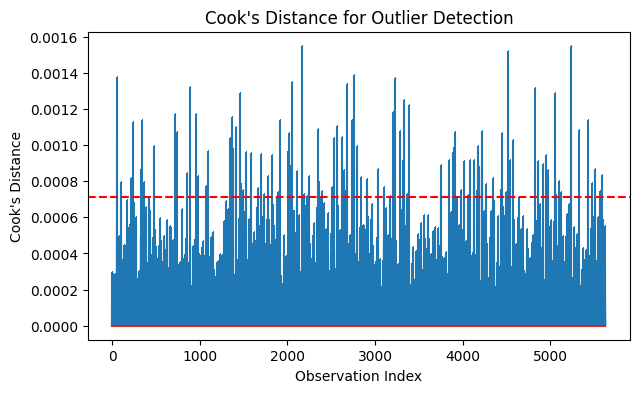

Cook's Distance threshold: 0.0007099751508697196
Number of influential points: 127


In [18]:
y_sm = y_train.astype(float)

#Convert X
#(start of code generated with GPT-5 on 9/11/25 at 8:25 PM)
X_sm = X_train_final.toarray() if hasattr(X_train_final, "toarray") else X_train_final
X_sm = sm.add_constant(X_sm)

#Fit OLS
ols_res = sm.OLS(y_sm, X_sm).fit()

#Get influence measures
influence = ols_res.get_influence()
cooks_d, pvals = influence.cooks_distance   #Cook's Distance value
#(end of code generated with GPT-5 on 9/11/25 at 8:25 PM)

threshold = 4 / len(cooks_d)

plt.figure(figsize=(7,4))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.axhline(threshold, color="red", linestyle="--")
plt.title("Cook's Distance for Outlier Detection")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.show()

print("Cook's Distance threshold:", threshold)
print("Number of influential points:", (cooks_d > threshold).sum())


The red dashed line represents the threshold above which points are said to have influence on the regression fit.

The majority of the blue spikes fall below the dotted line mean that they have little influence on the model. However, we see that there are 127 customers who have a disproportionately large effect on linear regression.

This demonstrates that **the no influential outliers assumption is violated** because there are customers who exert a pull on the coefficients.

### 2.4) Evaluate Performance

Below, we plot the difference between the actual and predicted values to see how well the model was able to predict the data.

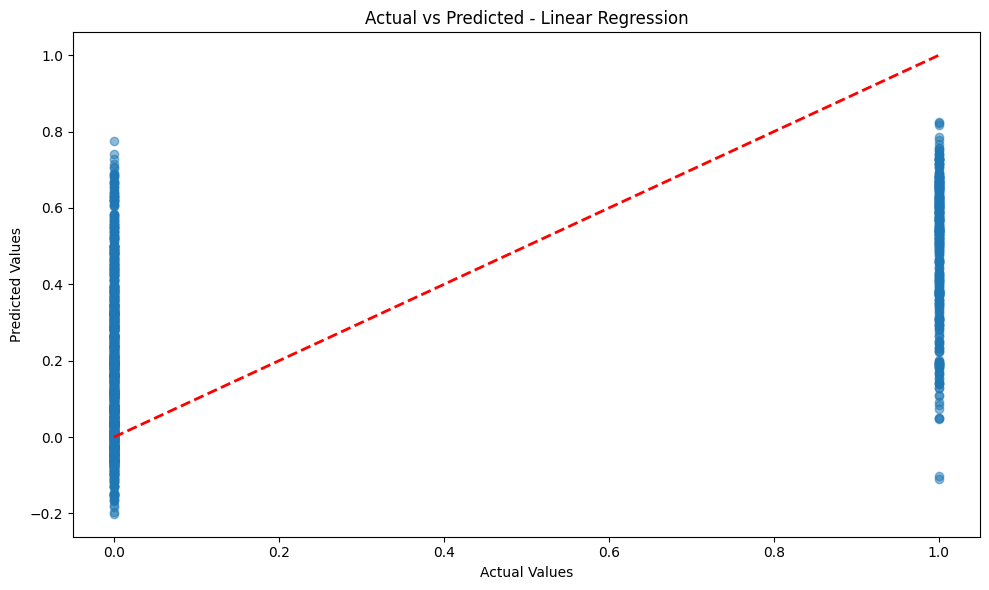

In [19]:
# Actual vs Predicted Plot
def plot_actual_vs_predicted(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted - {model_name}')
    plt.tight_layout()
    plt.show()

plot_actual_vs_predicted(y_test, linear_pred, 'Linear Regression')

From the initial evaluation, we see that **MSE = 0.13** and **$R^{2}$ = 0.31**, meaning that the model explains only 31% of the variance in churn.

This demonstrates that the **linear regression** is not a great fit for predicting churn and is struggling to capture what is likely a nonlinear relationship.

Furthermore, through the assumption checks, we see that the assumptions of **linearity, homoscedasticity, multicollinearity, and no influential outliers** are not upheld, demonstrating that linear regression is not suitable for modeling the data.

This is all confirmed in the plot above, which shows that linear regression did not model the spread of the data appropriately.

It appears that linear regression, while interpretable, does not perform well on the actual task of predicting churn.

## 3) Logistic Regression

Logistic regression is essentially a linear model for the log odds.

### 3.1) Make Logistic Regression Model

In [20]:
#Set up features and churn
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"),
         categorical_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

#Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [21]:
def evaluate_logistic_model(model, X_train, X_test, y_train, y_test, model_name, feat_names, top_n=20):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f"\n{model_name}:")
    print(f"Accuracy : {acc:.3f}")
    print(f"ROC AUC  : {auc:.3f}")
    print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3))

    #Coefficients aligned with transformed features (log-odds); also show odds ratios
    coefs = np.ravel(model.coef_)
    odds  = np.exp(coefs)
    print(f"\nTop {top_n} features by |coef|:")

    for f, c, o in sorted(zip(feat_names, coefs, odds), key=lambda x: abs(x[1]), reverse=True)[:top_n]:
        print(f"{f}: coef={c:.4f}, OR={o:.3f}")

    return model, y_pred, y_prob

In [22]:
#Fit and evaluate model
logistic_model_setup = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    max_iter=1000,
    class_weight="balanced",
)

logistic_model, logistic_pred, logistic_prob = evaluate_logistic_model(
    logistic_model_setup, X_train_final, X_test_final, y_train, y_test,
    "Logistic Regression", feature_names
)


Logistic Regression:
Accuracy : 0.750
ROC AUC  : 0.862

Confusion matrix:
 [[749 287]
 [ 65 308]]

Classification report:
               precision    recall  f1-score   support

           0      0.920     0.723     0.810      1036
           1      0.518     0.826     0.636       373

    accuracy                          0.750      1409
   macro avg      0.719     0.774     0.723      1409
weighted avg      0.814     0.750     0.764      1409


Top 20 features by |coef|:
Contract_Two year: coef=-1.5002, OR=0.223
tenure: coef=-1.2380, OR=0.290
InternetService_Fiber optic: coef=1.0421, OR=2.835
Contract_One year: coef=-0.6765, OR=0.508
TotalCharges: coef=0.5945, OR=1.812
StreamingMovies_Yes: coef=0.4161, OR=1.516
MonthlyCharges: coef=-0.4131, OR=0.662
OnlineSecurity_Yes: coef=-0.3666, OR=0.693
PhoneService_Yes: coef=-0.3500, OR=0.705
PaymentMethod_Electronic check: coef=0.3453, OR=1.412
PaperlessBilling_Yes: coef=0.3139, OR=1.369
StreamingTV_Yes: coef=0.3043, OR=1.356
TechSupport_Yes:

### 3.2) Interpret Coefficients

The OR (odds ratio) are an exponentiated version of the coefficients. It represents how likely customers with a certain features are likely to churn.
- OR > 1 means that the feature increases the odds of churn
- OR < 1 decreases the odds of churn



Based on the OR, the following coefficients **reduce** the likelihood of churn:
- **Contract_Two year (OR = 0.224)**: customers who have a 2 year contract are 78% less likely to churn than customers with other contracts.

- **Tenure (OR = 0.289):** Customers with a longer tenure are 72% less likely to churn, which makes sense because they are likely loyal customers who have been with the company for a long time.

- **Contract_One year (OR = 0.510)** : customers who have one-year contracts are 50% less likely to churn than those with month-to-month contracts.

- **OnlineSecurity_Yes (OR = 0.691), TechSupport_Yes (OR = 0.756)**: customers who have online security and technical support are less likely to churn.

- **PhoneService_Yes (OR = 0.707):** customers who have phone service have slightly lower chances of churning than those who don't.

- **MonthlyCharges (OR = 0.664)**: Higher monthly charges are associated with lower churn odds, possibly because they correlate with longer contracts or bundled services.

- **InternetService_No & various “No internet service” features (all OR ≈ 0.852):**  Customers without internet service are less likely to churn, maybe because they do not sign up for as many additional services.

Based on the OR, the following coefficients **increase** the likelihood of churn:
- **InternetService_Fiber optic (OR = 2.832)**: customers who use fiber optic are significantly more likely to churn, making it one of the strongest risk factors.

- **TotalCharges (OR = 1.816):** customers who have high total charges increase churn odds (perhaps long-term customers will eventually leave)

- **StreamingMovies_Yes (OR = 1.510), StreamingTV_Yes (OR = 1.355)** : customers who stream movies and TV increase odds of churning by 51% and 36%, respectively. This makes sense if the company does not offer the entertainment they want.

- **PaymentMethod_Electronic check (OR=1.414)**: customers who pay with electronic check have ~41% higher odds of churn

- **PaperlessBilling_Yes (OR=1.369)**: customers who use paperless billing have slightly increased churn odds by 37%

- **MultipleLines_Yes (OR = 1.302):** customers who have multiple phone lines slightly increase odds of churn by 30%

### 3.3) Check Assumptions

For logistic regression, we must check:

a) **Linearity**: resdiuals vs. predicted values plot

b) **Independence**: Durbin-Watson test

c) **No Multicollinearity**: VIF test

d) **No Influential Outliers**: Cook's Distance

#### 3.3a) Linearity

For logistic regression, the linearity check must be done differently. We will perform the Box-Tidwell test.

The Box-Tidwell test is a statistical test that checks continuous predictors by multiplying the term with its natural log and adding it to the model. If the interaction term is significanty, then linearity fails.

In [23]:
def box_tidwell_test(df, target, continuous_vars):
  results = {}
  df = df.copy()

  for var in continuous_vars:
      # Avoid log(0) by replacing zeros with a small value
      x = df[var].replace(0, 1e-6)
      df[f"{var}_log"] = x * np.log(x)

  # Build design matrix with original + interaction terms
  X = df[continuous_vars + [f"{v}_log" for v in continuous_vars]]
  X = sm.add_constant(X)
  y = df[target]

  # Fit logistic regression
  logit_model = sm.Logit(y, X).fit(disp=0)
  summary = logit_model.summary2().tables[1]

  # Collect p-values of the log terms
  for var in continuous_vars:
      pval = summary.loc[f"{var}_log", "P>|z|"]
      results[var] = pval

  return pd.Series(results, name="Box-Tidwell p-value")

In [24]:
continuous_vars = ["tenure", "MonthlyCharges", "TotalCharges"]
bt_results = box_tidwell_test(df, "Churn_num", continuous_vars)
print(bt_results)

tenure            3.760779e-08
MonthlyCharges    5.236603e-01
TotalCharges      2.223537e-02
Name: Box-Tidwell p-value, dtype: float64


The convention for Box-Tidwell tests is that values < 0.05 are statistically significant and thus violate linearity.

From the results, we see that tenure and TotalCharges fall in this category. Thus, **the assumption of linearity is violated.**

#### 3.3b) Independence

Unlike linear regression, we cannot use the Durbin-Watson test.

However, based on the data collection for the dataset, we know that **the assumption of independence is upheld** for logistic regression since each customer is independent of others.

#### 3.3c) No Multicollinearity

In [25]:
#Perform VIF
#Get transformed feature matrix (dense for VIF)
X_vif = preprocess.fit_transform(X)
if not isinstance(X_vif, np.ndarray):
    X_vif = X_vif.toarray()

feature_names = preprocess.get_feature_names_out()

#Add constant
X_vif = sm.add_constant(X_vif)

#Compute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = ["const"] + list(feature_names)
vif_data["VIF"] = [variance_inflation_factor(X_vif, i)
                   for i in range(X_vif.shape[1])]

print(vif_data.sort_values("VIF", ascending=False).head(20))

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                                 Feature           VIF
8                       PhoneService_Yes           inf
9         MultipleLines_No phone service           inf
13    OnlineSecurity_No internet service  4.372270e+09
12                    InternetService_No  4.372270e+09
21       StreamingTV_No internet service  1.465710e+09
17  DeviceProtection_No internet service  1.377655e+09
19       TechSupport_No internet service  6.739183e+08
23   StreamingMovies_No internet service  2.544196e+08
15      OnlineBackup_No internet service  2.312740e+08
2                         MonthlyCharges  8.649092e+02
11           InternetService_Fiber optic  1.482627e+02
24                   StreamingMovies_Yes  2.410972e+01
22                       StreamingTV_Yes  2.405675e+01
3                           TotalCharges  1.066981e+01
1                                 tenure  7.402539e+00
10                     MultipleLines_Yes  7.274130e+00
18                  DeviceProtection_Yes  6.922458e+00
16        

VIF quantifies multicollinearity.
- VIF = 1 means no correlation with other features
- VIF = 1-5 means there is slight but acceptable correlation
- VIF > 5 indicates problematic collinearity
- Values larger than 5 indicate strong collinearity

The results indicate high VIF values for many features. However, upon closer examination, this is because the dummy variables are reundant.

For example, PhoneService_Yes and MultipleLines_No phone service have VIF of infinity, which makes sense since they are directly related.

Using one-hot encoding for the categorical variables created linear dependence between the features and inflated the VIF. Though this does not heavily affect performance, to make a better model we should prune and encode features in a better method.

#### 3.3d) No Influential Outliers


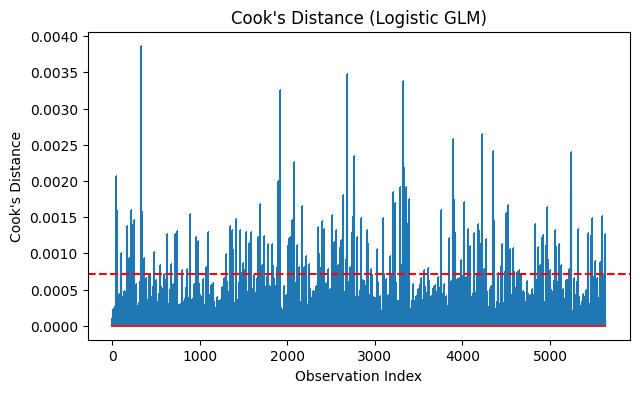

Cook's Distance threshold: 0.0007099751508697196
Number of influential points: 193


In [26]:
def cooks_distance_logistic(X_train_final, y_train):
    #Make statsmodel versions
    X_sm = X_train_final.toarray() if hasattr(X_train_final, "toarray") else np.asarray(X_train_final)
    X_sm = sm.add_constant(X_sm, has_constant='add')
    y_sm = np.asarray(y_train).astype(float)

    #Fit logistic via GLM Binomial
    glm = sm.GLM(y_sm, X_sm, family=sm.families.Binomial()).fit()

    infl = glm.get_influence(observed=False)  # expected information; more stable
    cooks_d = infl.cooks_distance[0]          # Cook's distance for GLM

    n = len(y_sm)
    threshold = 4.0 / n

    #Plot
    plt.figure(figsize=(7,4))
    plt.stem(np.arange(n), cooks_d, markerfmt=",")
    plt.axhline(threshold, color="red", linestyle="--")
    plt.title("Cook's Distance (Logistic GLM)")
    plt.xlabel("Observation Index")
    plt.ylabel("Cook's Distance")
    plt.show()

    print("Cook's Distance threshold:", threshold)
    print("Number of influential points:", int((cooks_d > threshold).sum()))

    return cooks_d, threshold

cooks_d, thr = cooks_distance_logistic(X_train_final, y_train)
idx = np.where(cooks_d > thr)[0]  #indices in TRAIN flagged by Cook's D

As with linear regression, the red dashed line represents the threshold above which points have influence on the model fit.

Here, we see that there are 193 influential points, demonstrating again that **the no influential outliers assumption is violated**.

### 3.4) Evaluate Performance

From the initial model performance results, we obtained the following statistics, which are explained below:

- **Accuracy = 0.750**: the Logistic Regression model correctly predicted ~75% of customers
- **ROC AUC = 0.862**: the model demonstrated it was able to discern between churn and non-churn customers accurately.
- **Confusion Matrix**:
  - *True Negatives (non-churn predicted correctly)*: 749
  - *False Positives (churn predicted incorrectly)*: 287
  - *False Negatives (non-churn predicted incorrectly)*: 65
  - *True Positives (churn predicted correctly)*: 308
  - This demonstrates the model was able to do a good job of distinguishing churn and non-churn (significantly better than linear regression)

- **Classification Report**:
  - **Class 0 (No Churn)**:
    - _Precision_: 0.920
    - *Recall*: 0.723
  - **Class 1 (Churn)**:
    - _Precision_: 0.518
    - _Recall_: 0.826
  - This indicates that the model predicted non-churners with good accuracy.
  - It also performed well in capturing churners, though there were some false positives.
  - This can be explained by the data having many more non-churners than churners, indicating that perhaps the model did not have enough examples of churner data to make accurate predictions.

In regards to the assumptions, the model was unable to meet the assumptions of **linearity, no multicollinearity, and no influential outliers.** However, these assumptions do not mean that the logistic regression model does not work, but rather that to have a more accurate version, remedies need to be made regarding what features are kept and how they are encoded.

Overall, logistic regression performed better than linear regression on the churn dataset. This is to be expected because of the binary nature of the churn variable, which linear regression is not suited to handle.

## 4) Generalized Additive Model (GAM)

Generalized Additive Model (GAM) assumes the outcome can be modeled as a sum of functions of each feature. It does so using B-splines that make it good for modeling nonlinear relationships.*

*From generalized-models-interpretability.ipynb notebook in course Github

In [27]:
#Redo encoding to not be one-hot
df['SeniorCitizen'] = df['SeniorCitizen'].map({0:'No', 1:'Yes'}).astype('category')

y = df['Churn_num'].values
X = df.drop(columns=['Churn_num','Churn']).copy()

num_cols = ['tenure','MonthlyCharges','TotalCharges']
cat_cols = [c for c in X.columns if c not in num_cols]

# Ensure categoricals are strings
X[cat_cols] = X[cat_cols].astype(str)

for c in cat_cols:
    X[c] = X[c].astype(str)

X_train_gam, X_test_gam, y_train_gam, y_test_gam = train_test_split(
    X, y, test_size=0.2, random_state=42)

#Preprocessing
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols),
    ],
    remainder='drop',
    sparse_threshold=0.0
)

X_train_gam_p = preprocess.fit_transform(X_train_gam)
X_test_gam_p  = preprocess.transform(X_test_gam)

n_num, n_cat = len(num_cols), len(cat_cols)
X_train_gam_p[:, n_num:] = np.rint(X_train_gam_p[:, n_num:]).astype(int)
X_test_gam_p[:,  n_num:] = np.rint(X_test_gam_p[:,  n_num:]).astype(int)

In [28]:
#Build GAM terms
term_objs = [s(i) for i in range(n_num)] + \
            [f(j) for j in range(n_num, n_num + n_cat)]

terms = term_objs[0]
for t in term_objs[1:]:
    terms += t

#Initialize LogisticGAM
gam = LogisticGAM(terms)
gam.gridsearch(X_train_gam_p, y_train_gam)
gam.fit(X_train_gam_p, y_train_gam)

#Make predictions
y_pred_gam  = gam.predict(X_test_gam_p)
y_proba_gam = gam.predict_proba(X_test_gam_p)

print(f"Accuracy: {accuracy_score(y_test_gam, y_pred_gam):.4f}")
print(f"ROC AUC:  {roc_auc_score(y_test_gam, y_proba_gam):.4f}")
print("Confusion matrix:\n", confusion_matrix(y_test_gam, y_pred_gam))
print(classification_report(y_test_gam, y_pred_gam, digits=3))

100% (11 of 11) |########################| Elapsed Time: 0:00:28 Time:  0:00:28


Accuracy: 0.8162
ROC AUC:  0.8634
Confusion matrix:
 [[940  96]
 [163 210]]
              precision    recall  f1-score   support

           0      0.852     0.907     0.879      1036
           1      0.686     0.563     0.619       373

    accuracy                          0.816      1409
   macro avg      0.769     0.735     0.749      1409
weighted avg      0.808     0.816     0.810      1409



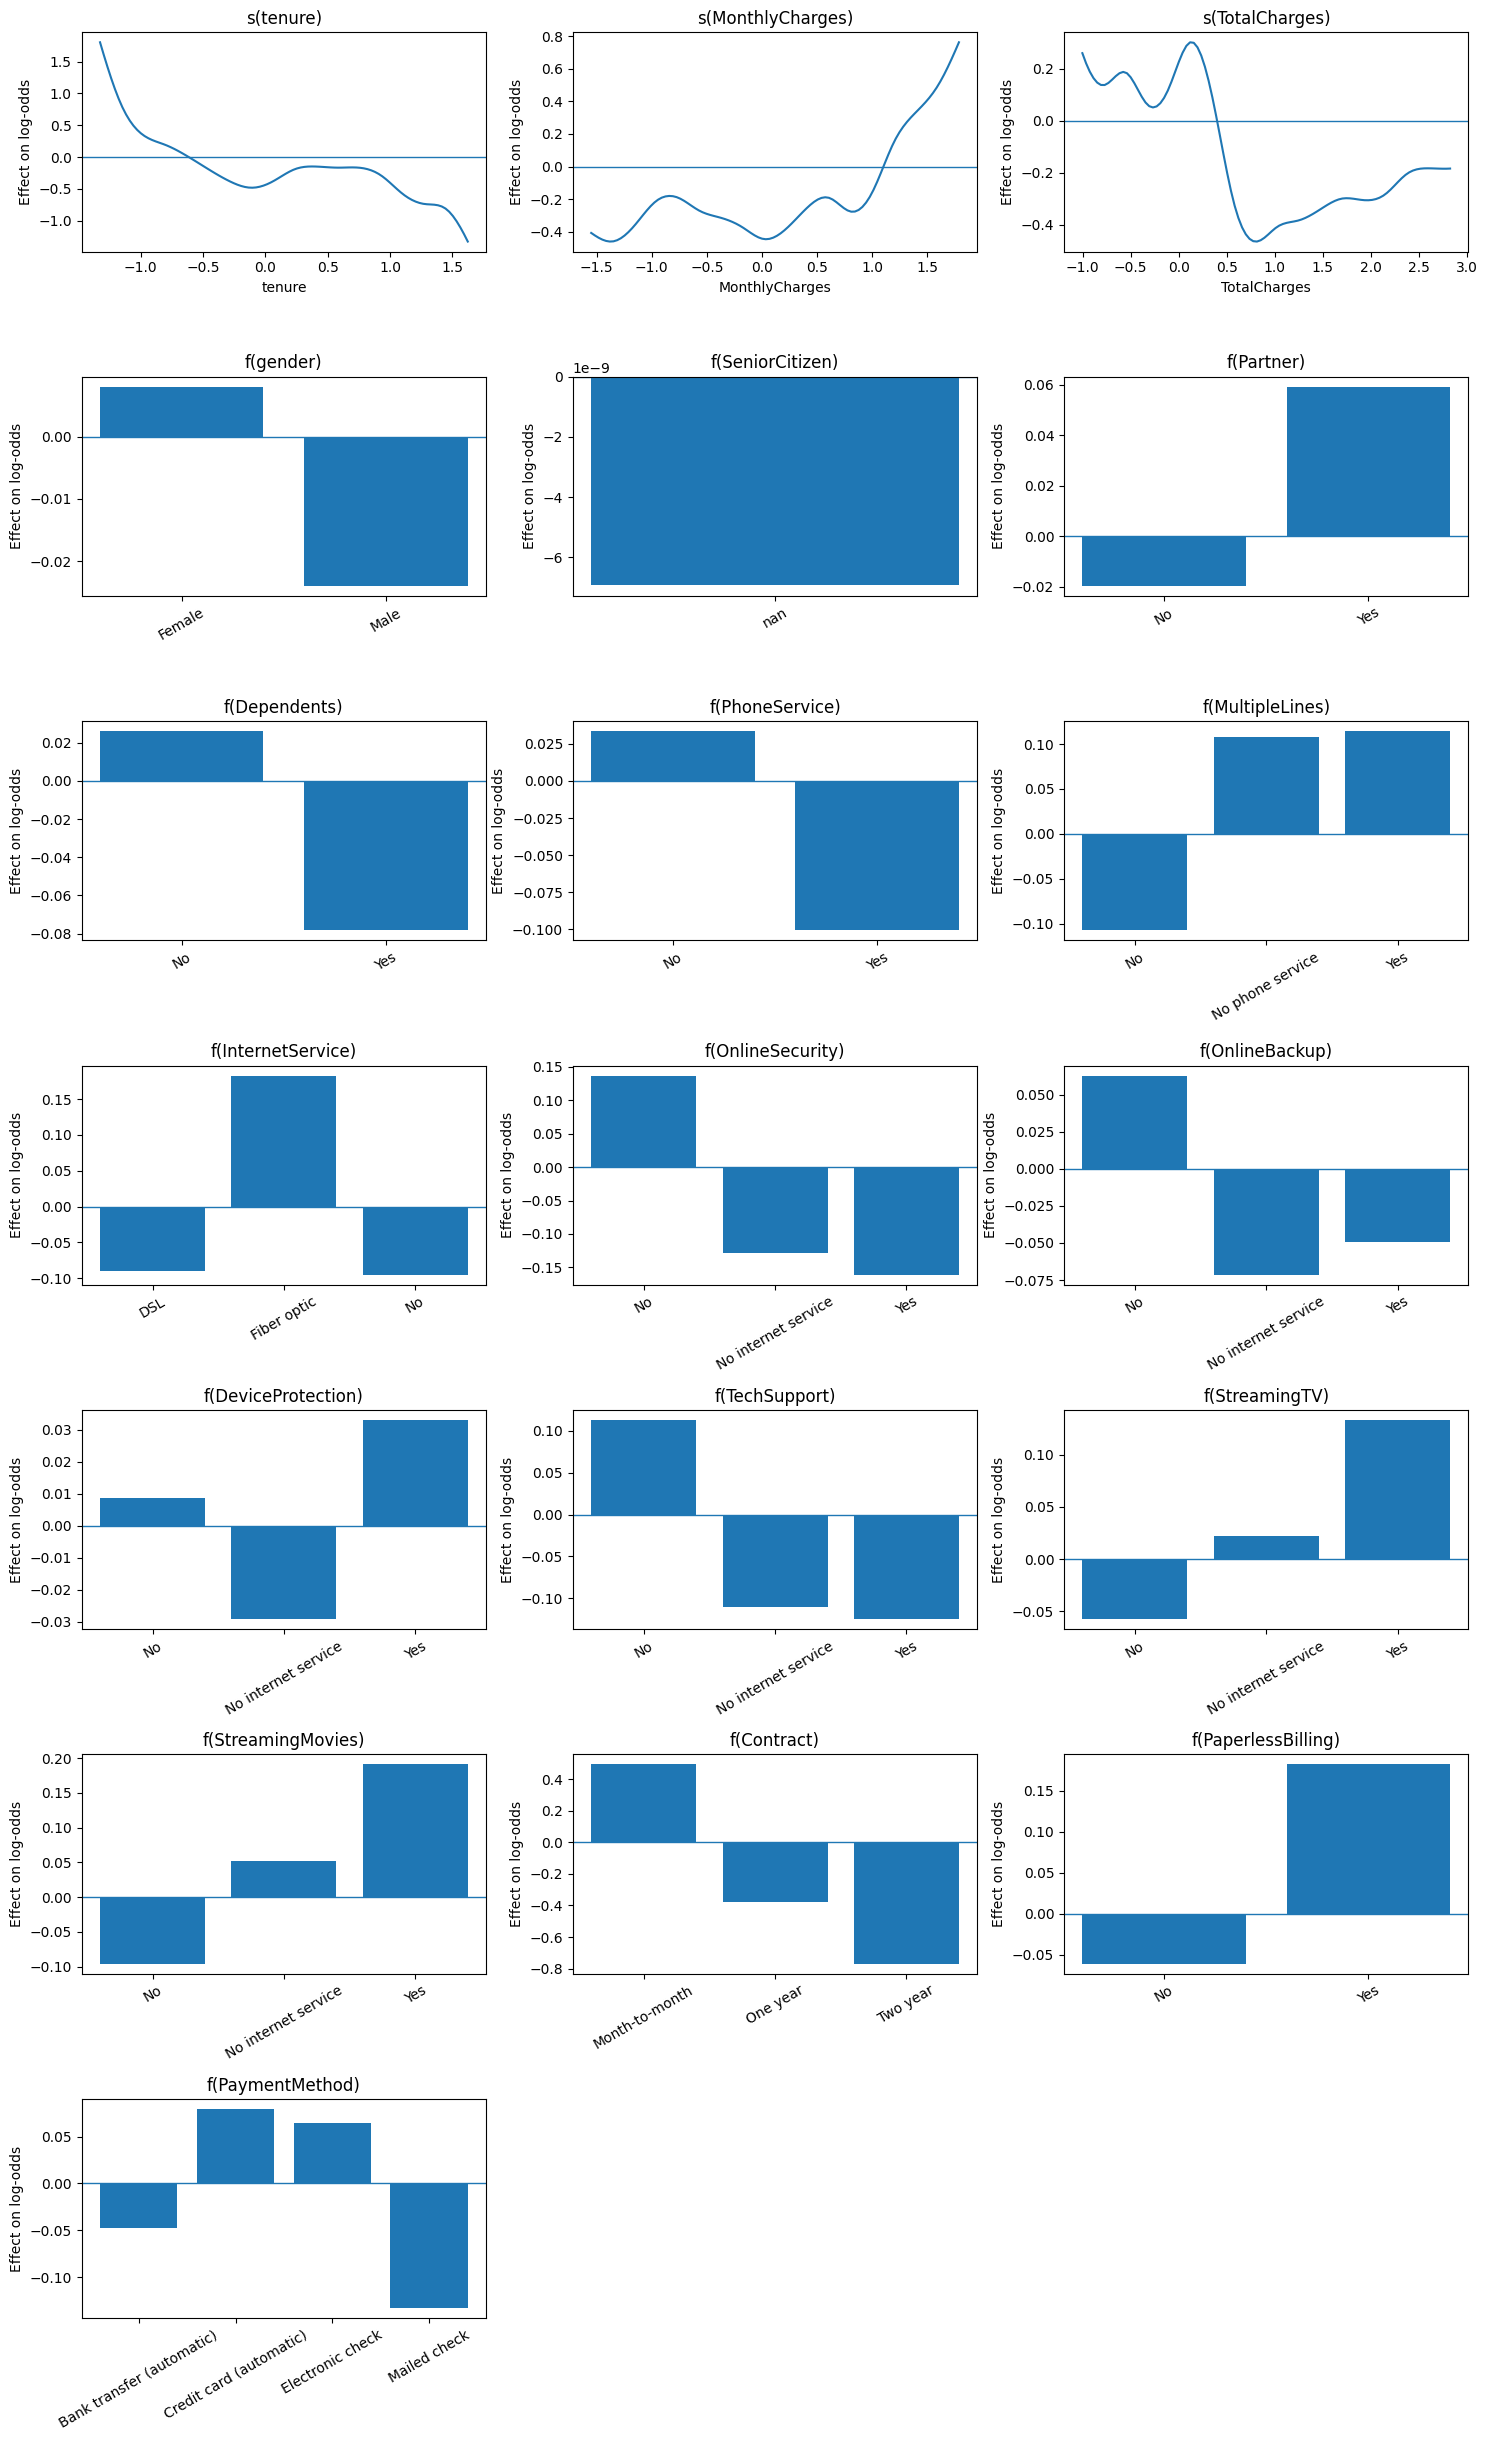

In [29]:
# Feature order in the GAM input matrix
feature_names = num_cols + cat_cols
n_num = len(num_cols)

# How many non-intercept terms?
plot_terms = [ (t_idx, t) for t_idx, t in enumerate(gam.terms) if not t.isintercept ]
nplots = len(plot_terms)
ncols = 3
nrows = math.ceil(nplots / ncols)

plt.figure(figsize=(5*ncols, 3.5*nrows))

for sp, (term_idx, term) in enumerate(plot_terms, start=1):
    ax = plt.subplot(nrows, ncols, sp)

    feat_idx = term.feature  # column index in X passed to gam (0..n_features-1)

    # Make a grid for this term only
    XX = gam.generate_X_grid(term=term_idx)
    pdp = gam.partial_dependence(term=term_idx, X=XX).ravel()

    if feat_idx < n_num:
        # numeric spline -> line plot
        ax.plot(XX[:, feat_idx], pdp)
        ax.axhline(0, lw=1)
        ax.set_title(f"s({feature_names[feat_idx]})")
        ax.set_xlabel(feature_names[feat_idx])
        ax.set_ylabel("Effect on log-odds")
    else:
        # categorical factor -> bars with category labels
        j = feat_idx - n_num
        cats = list(preprocess.named_transformers_['cat'].categories_[j])

        # codes for this factor in the grid
        codes = XX[:, feat_idx].astype(int)
        dfp = pd.DataFrame({"code": codes, "effect": pdp})
        dfp = dfp.groupby("code", as_index=False).mean()

        labels = [cats[c] if 0 <= c < len(cats) else "Unknown" for c in dfp["code"]]
        ax.bar(labels, dfp["effect"].values)
        ax.axhline(0, lw=1)
        ax.set_title(f"f({feature_names[feat_idx]})")
        ax.set_ylabel("Effect on log-odds")
        ax.tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

### 4.2) Interpret Model

From the statistics above, we can see the following:
- **Accuracy = 0.816**: This shows that GAM was more accurate than both linear and logistic regression.
- **ROC AUC = 0.863**: This demonstrates that GAM was able to separate customers that churn and customers that don't churn quite well.
- **Confusion Matrix**:
  - *True Negatives (non-churn predicted correctly)*: 940
  - *False Positives (churn predicted incorrectly)*: 96
  - *False Negatives (non-churn predicted incorrectly)*: 163
  - *True Positives (churn predicted correctly)*: 210
  - This further confirms that GAM was able to distinguish well between churn and non-churn.
  - Interestingly, whereas logistic regression had more False Positives, GAM struggled with False Negatives.

- **Additional Metrics**
  - *Specificity = 0.907*: the model identifies 90% of non-churners correctly
  - *Sensitivity/Recall = 0.563*: the model misses 44% of churners
  - *Precision = 0.686*: the model identifies churners correctly 69% of the time


Now, onto the graphs.
- The y-axis represents the odds of churn.
- Numeric features are plotted as curves while categorical features are represented as bars.
- Values above 0 indicate a higher risk of churn, whereas values below 0 indicate a lower risk of churn.


Given this, we can observe the following:
- **Numeric Features**:
  - *tenure*: decreasing sharply. This says that newer customers have very high churn risk (which intuitively makes sense as they have not yet built loyalty with the company)
  - *MonthlyCharges*: slowly increasing. This means that customers who are charged more are at a greater risk of churning.
  - *TotalCharges*: drops at larger totals (representing longtime loyal customers).

- **Categorical Features**:
  - *Partner/Dependent*: customers with partners and dependents are less likely to churn
  - *Gender/SeniorCitizen*: these features appear to have little impact on whether or not the customer churns.
  - *Contract*: customers with a month-to-month contract are at a high risk of churn (the form of the plan enables them to easily switch without losing money)
  - *PaperlessBiling*: Interestingly, customers who use paperless billing are more likely to churn.
  - *PaymentMethod*: customers who pay via electronic check have the highest churn likelihood
  - *InternetService: FiberOptic*: customers who have fiber optic internet are more likely to churn.
  - *OnlineSecurity/TechSupport/DeviceProtection/OnlineBackup*: customers who have the service are less likely to churn (maybe because they have already paid for the additional feature).
  - *PhoneService/MultipleLines*: minimal impact on churn

### 4.3) Check for Assumptions

GAM operates under the following assumptions:

  a) Independence

  b) No Multicollinearity

  c) No Influential Outliers

#### 4.3a) Independence

For GAM, we must check the independence of residuals.

To do this, we will perform the Durbin-Watson test.

In [30]:
#Perform Durbin-Watson test
p = gam.predict_proba(X_train_gam_p)

#Pearson residuals
eps = 1e-9
var = np.clip(p*(1-p), eps, None)
r_pearson = (y_train_gam - p) / np.sqrt(var)

dw = durbin_watson(r_pearson)
print(f"Durbin–Watson statistic (GAM): {dw:.3f}")

Durbin–Watson statistic (GAM): 1.978


Since this is around 2, that demonstrates that there is no autocorrelation and **the assumption of independence of residuals is upheld**

#### 4.3b) No Multicollinearity

To do this check, we will perform VIF

In [31]:
#Use VIF for numeric features
num_df = X_train_gam[num_cols].astype(float)
Xn = np.column_stack([num_df[c].values for c in num_cols])
vif = pd.Series([variance_inflation_factor(Xn, i) for i in range(Xn.shape[1])],
                index=num_cols)
print("VIF (numeric):\n", vif)

VIF (numeric):
 tenure            6.411602
MonthlyCharges    3.395187
TotalCharges      8.172729
dtype: float64


From this, we can see that the numeric features are highly correlated due to the high values. Again, this is to be expected because TotalCharges is calculated as tenure x MonthlyCharges.

Thus, the **assumption of no multicollinearity is violated**.

#### 4.3c) No Influential Outliers

To check for no influential outliers, we will use studentized residuals. Studentized residuals are essentially the raw residuals scaled by how uncertain we expect the point to be. Features with a large absolute value of the studentized residual are likely to be influential.

In [35]:
#Probabilities and residuals
eps = 1e-9
p = gam.predict_proba(X_train_gam_p)
var = np.clip(p*(1-p), eps, None)

r_dev = np.sign(y_train_gam - p) * np.sqrt(
    -2*(y_train_gam*np.log(p+eps) + (1-y_train_gam)*np.log(1-p+eps))
)

#Start of code generated with GPT-5 on 9/12/2025 at 6:00 PM
M = gam._modelmat(X_train_gam_p) if hasattr(gam, "_modelmat") else gam._X
w = np.sqrt(var).astype(float)

if sps.issparse(M):
    Z = (sps.diags(w) @ M).toarray()
else:
    Z = M * w[:, None] #End of code generated with GPT-5 on 9/12/2025 at 6:00 PM

#Studentized residuals ---
B = Z.T @ Z + 1e-6 * np.eye(Z.shape[1])
P = np.linalg.pinv(B)
H_diag = np.sum((Z @ P) * Z, axis=1)

r_student = r_dev / np.sqrt(np.clip(1 - H_diag, 1e-9, None))

#Output
thr = 3.0
flag_idx = np.where(np.abs(r_student) > thr)[0]
print(f"Flagged {len(flag_idx)} observations with |studentized deviance residual| > {thr}")


Flagged 5 observations with |studentized deviance residual| > 3.0


From this, we can see that there were 5 potentially influential outliers. However, this is a very small proportion compared to the size of the dataset, so **the assumption of no influential outliers** is upheld.

### 4.4) Evaluate Performance

From the initial results, we can see that GAM outperformed linear and logistic regression significantly, reaching the highest accuracy of **81.6%**. This is to be expected because GAMs are designed to model nonlinear relationships and are thus able to fit the data better than the other two models.

However, there was still an assumption that was violated (no multicollinearity). These can be remedied by removing correlated features (such as by dropping TotalCharges).

## 5) Model Comparison

The table below summarizes an overview of the models' performances.

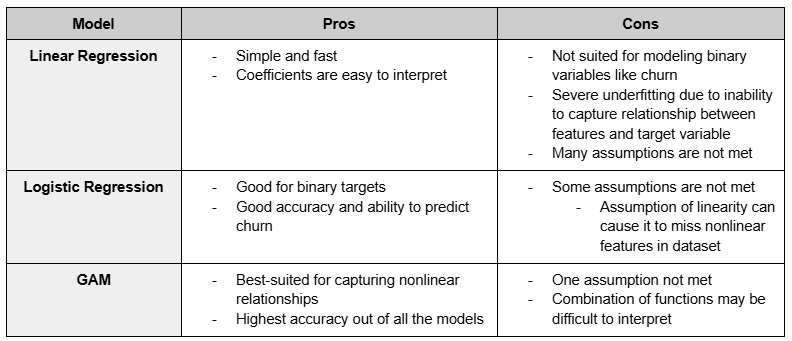

Overall, the best-performing model was **GAM** because it reached the highest accuracy (**81.6%** compared to Linear Regression's **31%** and Logistic Regression's **75%**)

One trend that stood out was that while the models were able to predict non-churners with high accuracy, they struggled when predicting individuals who *would* churn. This can be attributed to the skew in data (there was more data about non-churning customers than curning customers), hence why the model predictions were not as accurate.

## 6) Model Recommendation

The model recommendation I would give the company is to use **Generalized Additive Model (GAM)**. This is because GAM proved itself to be the best-performing model on the dataset. GAM's ability to capture nonlinear relationships exceeds that of logistic regression, providing more insight into potential customer behavior. Additionally, the visuals of each feature aid a bit with interpretability.

The main drawback of GAM is that the model is slightly more difficult to explain than logistic regression. If this is a major concern, then my second recommendation would be logistic regression because it is able to capture the relationship of the features to churn better than linear regression.